# Obtención de parámetros del vidrio solar

Para modelar el comportamiento del vidrio solar, y poder realizar así una comparación con las otras tecnologías fotovoltaicas, se ha elegido un módulo representativo de silicio monocristalino de la familia Onyx Solar. 

Lo que se prentende en este documento es modelar, mediante prueba y error, dicho módulo, de manera que se obtengan unos parámetros que proporcionen la misma curva IV que proporciona el fabricante mediante sus valores más representativos en su *datasheet*.

![Datasheet](SiMonoCristalino.png)

Perteneciente al [catálogo de Onyx](http://onyxsolardownloads.com/docs/ALL-YOU-NEED/Technical_Guide.pdf) en su página 30.

Para esto se ha utilizado la 

Se han comprobado los tres métodos de obtención de la curva IV disponibles, mediante la utilización de las funciones *calcparams_pvsyst, calcparams_desoto y calcparams_cec* pertenecientes a la librería [pvlib](https://pvlib-python.readthedocs.io/en/stable/). 

Estas funciones calculan cinco valores de parámetros para la ecuación de un solo diodo con la irradiancia efectiva y la temperatura de la celda. 

En primer lugar se utiliza el modelo PVsyst v6, y después se ha repetido el proceso para los modelos de De Soto y CEC. Estos últimos difieren entre sí, unicamente en que el modelo CEC incluye el parámetro *Adjust*, que modela el ajuste porcentual del coeficiente de temperatura para la corriente de cortocircuito.

In [1]:
from pvlib import pvsystem
import pandas as pd
import matplotlib.pyplot as plt
from module_parameters import mod_params_vidrio

#La curva IV del datasheet está calculada en condiciones standars de medida
#STC = 1000 W/m2; 25ºC
cases = [
    (1000, 25),
    (800, 25),
    (600, 25),
    (600, 30),
    (600, 35)
]

conditions = pd.DataFrame(cases, columns=['Geff', 'Tcell'])

In [2]:
IL_p, I0_p, Rs_p, Rsh_p, nNsVth_p = pvsystem.calcparams_pvsyst(
    conditions['Geff'],
    conditions['Tcell'],
    alpha_sc=mod_params_vidrio['alpha_sc'],
    I_L_ref=mod_params_vidrio['I_L_ref'],
    I_o_ref=mod_params_vidrio['I_o_ref'],
    R_sh_ref=mod_params_vidrio['R_sh_ref'],
    R_s=mod_params_vidrio['R_s'],
    EgRef=mod_params_vidrio['EgRef'],
    gamma_ref=mod_params_vidrio['gamma_ref'],
    mu_gamma=mod_params_vidrio['mu_gamma'],
    R_sh_0=mod_params_vidrio['R_sh_0'],
    cells_in_series=18
)

IL_d, I0_d, Rs_d, Rsh_d, nNsVth_d = pvsystem.calcparams_desoto(
    conditions['Geff'],
    conditions['Tcell'],
    alpha_sc=mod_params_vidrio['alpha_sc'],
    a_ref=mod_params_vidrio['a_ref'],
    I_L_ref=mod_params_vidrio['I_L_ref'],
    I_o_ref=mod_params_vidrio['I_o_ref'],
    R_sh_ref=mod_params_vidrio['R_sh_ref'],
    R_s=mod_params_vidrio['R_s'],
    EgRef=mod_params_vidrio['EgRef'],
)

IL_c, I0_c, Rs_c, Rsh_c, nNsVth_c = pvsystem.calcparams_cec(
    conditions['Geff'],
    conditions['Tcell'],
    alpha_sc=mod_params_vidrio['alpha_sc'],
    a_ref=mod_params_vidrio['a_ref'],
    I_L_ref=mod_params_vidrio['I_L_ref'],
    I_o_ref=mod_params_vidrio['I_o_ref'],
    R_sh_ref=mod_params_vidrio['R_sh_ref'],
    R_s=mod_params_vidrio['R_s'],
    EgRef=mod_params_vidrio['EgRef'],
    Adjust=0.9
)

In [3]:
curve_info_p = pvsystem.singlediode(
    photocurrent=IL_p,
    saturation_current=I0_p,
    resistance_series=Rs_p,
    resistance_shunt=Rsh_p,
    nNsVth=nNsVth_p,
    ivcurve_pnts=100,
    method='lambertw'
)

curve_info_d = pvsystem.singlediode(
    photocurrent=IL_d,
    saturation_current=I0_d,
    resistance_series=Rs_d,
    resistance_shunt=Rsh_d,
    nNsVth=nNsVth_d,
    ivcurve_pnts=100,
    method='lambertw'
)

curve_info_c = pvsystem.singlediode(
    photocurrent=IL_c,
    saturation_current=I0_c,
    resistance_series=Rs_c,
    resistance_shunt=Rsh_c,
    nNsVth=nNsVth_c,
    ivcurve_pnts=100,
    method='lambertw'
)

In [4]:
resultadosPvsyst = pd.DataFrame({
    'i_sc': curve_info_p['i_sc'],
    'v_oc': curve_info_p['v_oc'],
    'i_mp': curve_info_p['i_mp'],
    'v_mp': curve_info_p['v_mp'],
    'p_mp': curve_info_p['p_mp'],
})

resultadosDesoto = pd.DataFrame({
    'i_sc': curve_info_d['i_sc'],
    'v_oc': curve_info_d['v_oc'],
    'i_mp': curve_info_d['i_mp'],
    'v_mp': curve_info_d['v_mp'],
    'p_mp': curve_info_d['p_mp'],
})

resultadosCEC = pd.DataFrame({
    'i_sc': curve_info_c['i_sc'],
    'v_oc': curve_info_c['v_oc'],
    'i_mp': curve_info_c['i_mp'],
    'v_mp': curve_info_c['v_mp'],
    'p_mp': curve_info_c['p_mp'],
})


stcPvsyst=resultadosPvsyst.head(1)

stcDesoto=resultadosDesoto.head(1)

stcCEC=resultadosCEC.head(1)

print("·Modelo Pvsyst (STC):")
print(stcPvsyst,"\n")

print("·Modelo De Soto (STC):")
print(stcDesoto,"\n")

print("·Modelo CEC (STC):")
print(stcCEC,"\n")

print("·Valores buscados del datasheet:")
print("0  8.93     11         8.39      9         79")

·Modelo Pvsyst (STC):
      i_sc       v_oc     i_mp      v_mp       p_mp
0  8.99397  10.995864  8.33143  9.066507  75.536972 

·Modelo De Soto (STC):
      i_sc       v_oc      i_mp      v_mp       p_mp
0  8.99397  11.079134  8.331988  9.135167  76.114103 

·Modelo CEC (STC):
      i_sc       v_oc      i_mp      v_mp       p_mp
0  8.99397  11.079134  8.331988  9.135167  76.114103 

·Valores buscados del datasheet:
0  8.93     11         8.39      9         79


Observamos que los tres métodos coinciden de manera satisfactoriamente aproximada entre sí.

A continuación podemos ver una comparación gráfica de las tres curvas en STC:

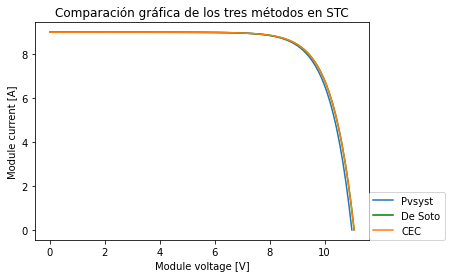

<Figure size 432x288 with 0 Axes>

In [5]:
plt.figure()
i=0
plt.plot(curve_info_p['v'][i], curve_info_p['i'][i], label='Pvsyst')
v_mp = curve_info_p['v_mp'][i]
i_mp = curve_info_p['i_mp'][i]
    
plt.plot(curve_info_d['v'][i], curve_info_d['i'][i], label='De Soto', color='g')
v_mp = curve_info_d['v_mp'][i]
i_mp = curve_info_d['i_mp'][i]
    
plt.plot(curve_info_c['v'][i], curve_info_c['i'][i], label='CEC')
v_mp = curve_info_c['v_mp'][i]
i_mp = curve_info_c['i_mp'][i]

plt.legend(loc=(1.0, 0))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.title('Comparación gráfica de los tres métodos en STC')
plt.show()
plt.gcf().set_tight_layout(True)

Se presentan aquí las curvas generadas para distintos valores de irradiancia y temperatura:

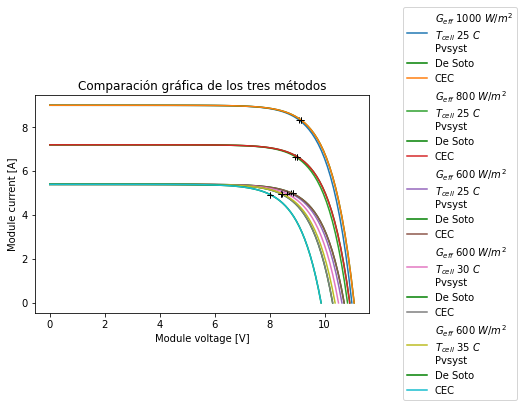

<Figure size 432x288 with 0 Axes>

In [6]:
plt.figure()
for i, case in conditions.iterrows():

    label = (
        "$G_{eff}$ " + f"{case['Geff']} $W/m^2$\n"
        "$T_{cell}$ " + f"{case['Tcell']} $C$"
    )
    
    plt.plot(curve_info_p['v'][i], curve_info_p['i'][i], label=label+'\nPvsyst')
    v_mp = curve_info_p['v_mp'][i]
    i_mp = curve_info_p['i_mp'][i]
    plt.plot([v_mp], [i_mp], ls='', marker='+', c='k')    
    plt.plot(curve_info_d['v'][i], curve_info_d['i'][i], label='De Soto', color='g')
    v_mp = curve_info_d['v_mp'][i]
    i_mp = curve_info_d['i_mp'][i]
    plt.plot([v_mp], [i_mp], ls='', marker='+', c='k')
    plt.plot(curve_info_c['v'][i], curve_info_c['i'][i], label='CEC')
    v_mp = curve_info_c['v_mp'][i]
    i_mp = curve_info_c['i_mp'][i]
    plt.plot([v_mp], [i_mp], ls='', marker='+', c='k')

plt.legend(loc=(1.1, -0.4))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.title('Comparación gráfica de los tres métodos')
plt.show()
plt.gcf().set_tight_layout(True)

In [7]:
print("Modelo Pvsyst:")
print(resultadosPvsyst,"\n")

print("Modelo De Soto:")
print(resultadosDesoto,"\n")

print("Modelo CEC:")
print(resultadosCEC,"\n")

Modelo Pvsyst:
       i_sc       v_oc      i_mp      v_mp       p_mp
0  8.993970  10.995864  8.331430  9.066507  75.536972
1  7.195176  10.838118  6.656448  8.936440  59.484943
2  5.396383  10.634737  4.980912  8.768745  43.676349
3  5.396383  10.509385  4.965153  8.628180  42.840235
4  5.396383  10.385304  4.962295  8.466817  42.014846 

Modelo De Soto:
       i_sc       v_oc      i_mp      v_mp       p_mp
0  8.993970  11.079134  8.331988  9.135167  76.114103
1  7.195181  10.920260  6.657322  9.004169  59.943656
2  5.396389  10.715436  4.982057  8.835284  44.017889
3  5.396389  10.296475  4.964015  8.416928  41.781753
4  5.396389   9.876924  4.933882  8.017383  39.556818 

Modelo CEC:
       i_sc       v_oc      i_mp      v_mp       p_mp
0  8.993970  11.079134  8.331988  9.135167  76.114103
1  7.195181  10.920260  6.657322  9.004169  59.943656
2  5.396389  10.715436  4.982057  8.835284  44.017889
3  5.396389  10.296475  4.964015  8.416928  41.781753
4  5.396389   9.876924  4.933882  8

Podemos observar una similitud de valores muy ajustada frente a variaciones de irradiación y que, excepto a altas temperaturas, mantiene de manera adecuada esa correlación en variaciones de temperatura.

A continuación vamos a hacer un breve análisis de la variación que sufren las curvas al modificar el parámetro de transparencia del módulo. 

Se utilizará para esto la curva obtenida por el método de pvsyst a STC.

Indicar que los cálculos anteriores se han realizado para una transparencia del 48%, tal y como indica el *datasheet*.

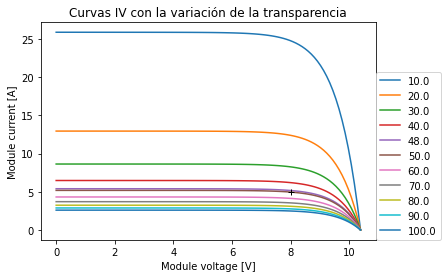

<Figure size 432x288 with 0 Axes>

In [8]:
#La transparencia del módulo del datasheet es de 48%

plt.figure()

Light_Transmission = [0.1, 0.2, 0.3, 0.4, 0.48, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for x in Light_Transmission:
    plt.plot(curve_info_p['v'][i], curve_info_p['i'][i]*0.48/x, label=100*x)
v_mp = curve_info_c['v_mp'][i]
i_mp = curve_info_c['i_mp'][i]
plt.plot([v_mp], [i_mp], ls='', marker='+', c='k')


plt.legend(loc=(1.0, 0))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.title('Curvas IV con la variación de la transparencia')
plt.show()
plt.gcf().set_tight_layout(True)

La variación de la transparencia, como era de esperar, tiene un efecto sobre la curva similar a la variación de la irradiación. 